<a href="https://colab.research.google.com/github/ece324-2019/AER202/blob/master/aer202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision
from torchvision import datasets,transforms,models
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import *

import time
import json
import copy
import os
import argparse
from PIL import Image
from collections import OrderedDict

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
#from utils import process_images

In [3]:

# DECLARE DIRECTORIES
# train_dir = 'datasets/test_cropped'
# FULL_IMAGE_DIR = 'datasets/full'

# Google Colab - pull dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
FULL_IMAGE_DIR = '/content/drive/My Drive/Colab Notebooks/full'

In [19]:
# Args
def parse_arguments():
    parser = argparse.ArgumentParser(
        prog='AER202', description='Tool that uses machine learning to identify planes from a photo.')
    parser.add_argument('--batch_size', '-b', type=int, default=32,
                        help='Size of batches to use during training')
    parser.add_argument('--learning_rate', '-lr', type=float,
                        default=0.01, help='Learning rate to use during training')
    parser.add_argument('--epochs', '-e', type=int, default=20,
                        help='Number of epochs to use during training')
    parser.add_argument('--eval_every', '-ee', type=int, default=10,
                        help='Number of epochs to wait before evaluating accuracy of model')
    parser.add_argument('--seed', '-s', type=int, default=1,
                        help='Seed to use for any random functions')
    parser.add_argument('--disable_cuda', '-dcuda',
                        action='store_true', help='Disable CUDA')
    parser.add_argument('--process_images', '-pi', action='store_true',
                        help='Prepare images for training by performing actions such as cropping and downscaling')
    parser.add_argument('--small_dataset', '-sd', action='store_true',
                        help='Train and validate on a smaller test dataset for quick testing')
    
    # For local running
    # args = parser.parse_args()

    # For Google Colab
    args = parser.parse_args(args=[])

    return args


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


# Get class (label) names
def get_classes(is_small_dataset: bool):
    """Get names of classes from the immediate subdirectories of the main image directory"""
    images_dir = TEST_IMAGE_DIR if is_small_dataset else FULL_IMAGE_DIR
    classes = next(os.walk(images_dir))[1]

    return classes


def one_hot(x, dim):
    vec = torch.zeros(dim)
    vec[x] = 1.0
    return vec


def evaluate(model, val_loader, cuda_enabled):
    total_corr = 0

    for i, batch in enumerate(val_loader):
        features, label = batch
        if cuda_enabled:
            features = features.cuda()
            label = label.cuda()

        # Run model on data
        prediction = model(features)

        # Check number of correct predictions
        torch_max = torch.max(prediction, 1)
        for j in range(prediction.size()[0]):
            if torch_max[1][j].item() == label[j].item():
                total_corr += 1

    return float(total_corr) / len(val_loader.dataset)


# Create Custom Classifier
def build_classifier(num_in_features, hidden_layers, num_out_features):
    classifier = nn.Sequential()
    # when we don't have any hidden layers
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, num_out_features))
        # when we have hidden layers
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))

        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc' + str(i + 1), nn.Linear(h1, h2))
            classifier.add_module('relu' + str(i + 1), nn.ReLU())
            classifier.add_module('drop' + str(i + 1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))

    return classifier


# Training Loop
def train_model(model, criterion, optimizer, sched, num_epochs=5, device='cuda'):
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # sched.step()
                        loss.backward()

                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if (phase == 'train'):
                train_results.append([epoch_loss, epoch_acc])
            if (phase == 'valid'):
                valid_results.append([epoch_loss, epoch_acc])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                model_save_name = "resnetCars.pt"
                path = F"/content/drive/My Drive/{model_save_name}"
                torch.save(model.state_dict(), path)

        print()

    # Calculating time it took for model to train
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_results, valid_results


CUDA is available!  Training on GPU ...


Total Number of Images:  1500
Number of Images in Train:  1350
Number of Images in Valid:  150
Number of Aircraft Types:  5
 Sizes of Datasets:  150 1350
Linear(in_features=2048, out_features=1000, bias=True)
Sequential(
  (fc0): Linear(in_features=2048, out_features=5, bias=True)
)
Epoch 1/20
----------
train
train Loss: 1.7273 Acc: 0.3022
valid
valid Loss: 5.9543 Acc: 0.1667

Epoch 2/20
----------
train
train Loss: 1.8472 Acc: 0.3407
valid
valid Loss: 2.9837 Acc: 0.3333

Epoch 3/20
----------
train
train Loss: 1.4618 Acc: 0.4126
valid
valid Loss: 2.9719 Acc: 0.3600

Epoch 4/20
----------
train
train Loss: 1.2762 Acc: 0.4630
valid
valid Loss: 1.2907 Acc: 0.4333

Epoch 5/20
----------
train
train Loss: 1.1635 Acc: 0.5163
valid
valid Loss: 1.3782 Acc: 0.5067

Epoch 6/20
----------
train
train Loss: 1.0910 Acc: 0.5430
valid
valid Loss: 0.9978 Acc: 0.5533

Epoch 7/20
----------
train
train Loss: 1.0507 Acc: 0.5593
valid
valid Loss: 1.7121 Acc: 0.4533

Epoch 8/20
----------
train
train Los

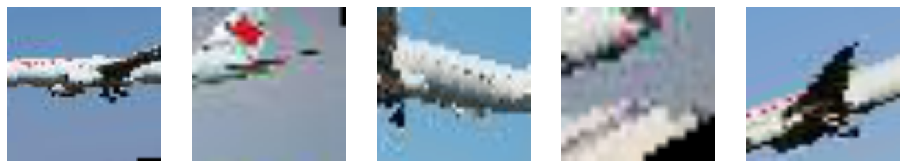

In [21]:
# def main():

args = parse_arguments()


torch.manual_seed(args.seed)
cuda_enabled = True if torch.cuda.is_available() and not args.disable_cuda else False

# If images have not been pre-processed, crop and resize here when given flag
# if args.process_images:
#     process_images(args.small_dataset)

# Transform with data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        # transforms.RandomResizedCrop(299),  #size for inception architecture
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        # transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



batch_size = args.batch_size

# Instantiate dataset from train_dir
dataset = datasets.ImageFolder(FULL_IMAGE_DIR, transform=data_transforms['train'])

# splitting our data
valid_size = int(0.1 * len(dataset))
train_size = len(dataset) - valid_size
dataset_sizes = {'train': train_size, 'valid': valid_size}

# now we get our datasets
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Loading datasets into dataloader
dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
               'valid': DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)}

print("Total Number of Images: ", len(dataset))
print("Number of Images in Train: ", len(train_dataset))
print("Number of Images in Valid: ", len(valid_dataset))
print("Number of Aircraft Types: ", len(dataset.classes))

#print(dataset.classes[0])

# Show training images
print(" Sizes of Datasets: ", len(valid_dataset), len(train_dataset))
# Displaying Training Images
images, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(figsize=(16, 5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    # ax.set_title(label_map[class_names[labels[ii].item()]])
    imshow(images[ii], ax=ax, normalize=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Selection of model
model_name = 'resnet'  # vgg

hidden_layers = None  # [1050,500]

# Densenet
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
# VGGNet
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
# Resnet
elif model_name == 'resnet':
    model = models.resnet152(pretrained=True)
    # model = models.resnet34(pretrained=True)
    num_in_features = 2048  # 512
    print(model.fc)
# Inception
elif model_name == 'inception':
    model = models.inception_v3(pretrained=True)
    model.aux_logits = False
    num_in_features = 2048
    print(model.fc)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

# Encode data
label_encoder = LabelEncoder()
classes = get_classes(args.small_dataset)
int_classes = label_encoder.fit_transform(classes)
oneh_encoder = OneHotEncoder(categories='auto')
int_classes = int_classes.reshape(-1, 1)
oneh_labels = oneh_encoder.fit_transform(int_classes).toarray()

target_transform = torchvision.transforms.Compose(
    [torchvision.transforms.transforms.Lambda(lambda x: one_hot(x, len(classes)))])

# Freezing parameters
for param in model.parameters():
    param.require_grad = False

# define our hidden layers

classifier = build_classifier(num_in_features, hidden_layers, len(dataset.classes))
print(classifier)

# Defining model hyperparameters
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(
        model.parameters())  # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
    # Decay Learning Rate by a factor of 0.1 every 4 epochs
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
elif model_name == 'resnet':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)
elif model_name == 'inception':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
else:
    pass

# move model to GPU
model.to(device)
model, train_results, valid_results = train_model(model, criterion, optimizer, sched, args.epochs)




#
# if __name__ == '__main__':
#     main()